# Fast TopK elements

Looking for the top k elements is something needed to implement a simple k nearest neighbors. The implementation *scikit-learn* is using relies on *numpy*: [_kneighbors_reduce_func](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neighbors/_base.py#L496). *mlprodict* also contains a C++ implementation of the same function. Let's compare them.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Two implementations

We assume we are looking for the `k` nearest elements of every row of matrix `X` which is a dense matrix of doubles.

In [3]:
import numpy.random as rnd
from sklearn.neighbors._base import KNeighborsMixin

mixin = KNeighborsMixin()

In [4]:
def topk_sklearn(X, k):
    return mixin._kneighbors_reduce_func(X, 0, k, False)
    
X = rnd.randn(5, 10)
ind = topk_sklearn(X, 3)
ind

array([[1, 4, 3],
       [5, 6, 7],
       [3, 1, 9],
       [7, 9, 6],
       [9, 5, 1]], dtype=int64)

Now the implementation with *mlprodict* (C++) available at [topk_element_min](https://github.com/sdpython/mlprodict/blob/master/mlprodict/onnxrt/ops_cpu/_op_onnx_numpy.cpp#L201). It uses [heap](https://en.wikipedia.org/wiki/Heap_(data_structure)).

In [5]:
from mlprodict.onnxrt.ops_cpu._op_onnx_numpy import topk_element_min_double

In [6]:
def topk_cpp(X, k):
    return topk_element_min_double(X, k, True)
    
ind = topk_cpp(X, 3)
ind

array([[1, 4, 3],
       [5, 6, 7],
       [3, 1, 9],
       [7, 9, 6],
       [9, 5, 1]], dtype=int64)

## Speed comparison by size

In [7]:
%timeit topk_sklearn(X, 3)

32.2 µs ± 5.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
%timeit topk_cpp(X, 3)

3.35 µs ± 630 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Quite a lot faster on this simple example. Let's look for bigger matrices.

In [9]:
X = rnd.randn(1000, 100)

In [10]:
%timeit topk_sklearn(X, 10)

1.65 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%timeit topk_cpp(X, 10)

415 µs ± 44.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
from cpyquickhelper.numbers import measure_time
from tqdm import tqdm
from pandas import DataFrame

rows = []
for n in tqdm(range(1000, 10001, 1000)):
    X = rnd.randn(n, 1000)
    res = measure_time('topk_sklearn(X, 20)',
                       {'X': X, 'topk_sklearn': topk_sklearn},
                       div_by_number=True,
                       number=2, repeat=2)
    res["N"] = n
    res["name"] = 'topk_sklearn'
    rows.append(res)
    res = measure_time('topk_cpp(X, 20)',
                       {'X': X, 'topk_cpp': topk_cpp},
                       div_by_number=True,
                       number=4, repeat=4)
    res["N"] = n
    res["name"] = 'topk_cpp'
    rows.append(res)

df = DataFrame(rows)
df.head()

100%|██████████| 10/10 [00:07<00:00,  1.04s/it]


,average,deviation,min_exec,max_exec,repeat,number,context_size,N,name
0,0.017167,0.001391,0.015776,0.018557,2,2,240,1000,topk_sklearn
1,0.001782,0.000171,0.001589,0.002026,4,4,240,1000,topk_cpp
2,0.031707,0.000047,0.031660,0.031755,2,2,240,2000,topk_sklearn
3,0.003358,0.000045,0.003287,0.003400,4,4,240,2000,topk_cpp
4,0.048744,0.000255,0.048489,0.048999,2,2,240,3000,topk_sklearn


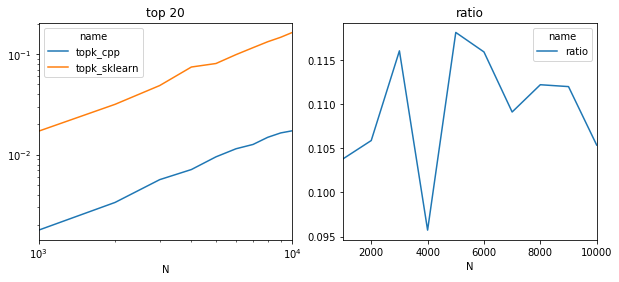

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
piv = df.pivot("N", "name", "average")
piv.plot(ax=ax[0], logy=True, logx=True)
ax[0].set_title("top 20")
piv["ratio"] = piv["topk_cpp"] / piv["topk_sklearn"]
piv[["ratio"]].plot(ax=ax[1])
ax[1].set_title("ratio");

## Speed comparison by k

In [14]:
rows = []
X = rnd.randn(2000, 1000)
for k in tqdm(list(range(1, 20)) + list(range(20, 1000, 20))):
    res = measure_time('topk_sklearn(X, k)',
                       {'X': X, 'topk_sklearn': topk_sklearn, 'k': k},
                       div_by_number=True,
                       number=2, repeat=2)
    res["k"] = k
    res["name"] = 'topk_sklearn'
    rows.append(res)
    res = measure_time('topk_cpp(X, k)',
                       {'X': X, 'topk_cpp': topk_cpp, 'k': k},
                       div_by_number=True,
                       number=2, repeat=2)
    res["k"] = k
    res["name"] = 'topk_cpp'
    rows.append(res)

df = DataFrame(rows)
df.head()

100%|██████████| 68/68 [00:32<00:00,  1.09it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,k,name
0,0.013855,2.748000e-04,0.013580,0.014130,2,2,240,1,topk_sklearn
1,0.001798,2.000000e-07,0.001798,0.001799,2,2,240,1,topk_cpp
2,0.023223,3.560000e-05,0.023188,0.023259,2,2,240,2,topk_sklearn
3,0.000938,6.900000e-06,0.000931,0.000945,2,2,240,2,topk_cpp
4,0.027385,1.033425e-03,0.026352,0.028419,2,2,240,3,topk_sklearn


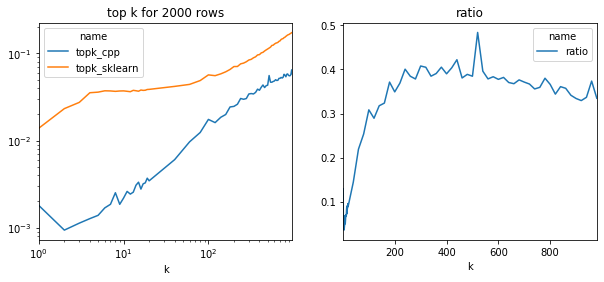

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
piv = df.pivot("k", "name", "average")
piv.plot(ax=ax[0], logy=True, logx=True)
ax[0].set_title("top k for 2000 rows")
piv["ratio"] = piv["topk_cpp"] / piv["topk_sklearn"]
piv[["ratio"]].plot(ax=ax[1])
ax[1].set_title("ratio")
ax[0].set_xlabel("k")
ax[1].set_xlabel("k");

The implementation is half faster in all cases and much more efficient for small values which is usually the case for the nearest neighbors. This implementation is using *openmp*, maybe that's why it gets 50% faster on this two cores machine.